In [ ]:
import torch
from torch import nn, Tensor
import numpy as np
from torchvision.utils import save_image

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# 1. Dataset

In [ ]:
import torchvision
img_size = 32

transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((img_size, img_size)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.5], std=[0.5])
])

images = torchvision.datasets.MNIST(root='./mnist_data', train=True, download=True, transform=transform)

In [ ]:
BATCH_SIZE = 64
dataloader = torch.utils.data.DataLoader(images, batch_size=BATCH_SIZE, shuffle=True)

# 2. Model

In [ ]:
channels = 1
img_shape = (channels, img_size, img_size)
latent_dim = 100

In [ ]:
class Generator(nn.Module):
  def __init__(self):
    super().__init__()
    self.model = nn.Sequential(
        nn.Linear(latent_dim, 256),
        nn.BatchNorm1d(256),
        nn.LeakyReLU(0.2, inplace=True),

        nn.Linear(256, 512),
        nn.BatchNorm1d(512),
        nn.LeakyReLU(0.2,inplace=True),

        nn.Linear(512, 1024),
        nn.BatchNorm1d(1024),
        nn.LeakyReLU(0.2, inplace=True),

        nn.Linear(1024, int(np.prod(img_shape))),
        nn.Tanh()
    )

  def forward(self, z):
      img = self.model(z)
      img = img.view(img.size(0), *img_shape)
      return img

In [ ]:
class Descriminator(nn.Module):
  def __init__(self):
    super().__init__()
    self.model = nn.Sequential(
        nn.Linear(int(np.prod(img_shape)), 512),
        nn.LeakyReLU(0.2, inplace=True),

        nn.Linear(512, 256),
        nn.LeakyReLU(0.2, inplace=True),

        nn.Linear(256, 1),
        nn.Sigmoid()
    )

  def forward(self, img):
    img_flat = img.view(img.size(0),-1)
    validity = self.model(img_flat)
    return validity


In [ ]:
generator = Generator()
discriminator = Descriminator()


In [ ]:
generator.to(device)

Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Linear(in_features=256, out_features=512, bias=True)
    (4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Linear(in_features=512, out_features=1024, bias=True)
    (7): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Linear(in_features=1024, out_features=1024, bias=True)
    (10): Tanh()
  )
)

In [ ]:
discriminator.to(device)

Descriminator(
  (model): Sequential(
    (0): Linear(in_features=1024, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Linear(in_features=256, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

# 3. Training

In [ ]:
import os
os.makedirs('images', exist_ok=True)
save_interval = 10

In [ ]:
EPOCHS = 200

optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0001)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0002)

criterion = nn.BCELoss()

hist = {
    'train_G_loss': [],
    'train_D_loss': [],
}

for epoch in range(EPOCHS):
  running_G_loss = 0.0
  running_D_Loss = 0.0

  for i, (imgs, _) in enumerate(dataloader):

    real_imgs = imgs.to(device)
    real_labels = torch.ones(imgs.shape[0], 1).to(device)
    fake_labels = torch.zeros(imgs.shape[0], 1).to(device)

    # Train Generator
    optimizer_G.zero_grad()

    z = torch.randn((imgs.shape[0], latent_dim)).to(device)

    gen_imgs = generator(z)
    G_loss = criterion(discriminator(gen_imgs), real_labels)
    running_G_loss += G_loss.item()

    G_loss.backward()
    optimizer_G.step()

    # Train Discriminator
    optimizer_D.zero_grad()
    real_loss = criterion(discriminator(real_imgs), real_labels)
    fake_loss = criterion(discriminator(gen_imgs.detach()), fake_labels)
    D_loss = (real_loss + fake_loss)/2
    running_D_Loss += D_loss.item()
    D_loss.backward()
    optimizer_D.step()
  epoch_G_loss = running_G_loss / len(dataloader)
  epoch_D_loss = running_D_Loss / len(dataloader)
  print(f'Epoch [{epoch+1}/{EPOCHS}], Train G Loss: {epoch_G_loss:.4f}, Train D Loss: {epoch_D_loss:.4f}')
  hist['train_G_loss'].append(epoch_G_loss)
  hist['train_D_loss'].append(epoch_D_loss)

  if epoch % save_interval == 0:
    save_image(gen_imgs.data[:25], f'images/epoch_{epoch}.png')

Epoch [1/200], Train G Loss: 8.8268, Train D Loss: 0.0528
Epoch [2/200], Train G Loss: 7.0191, Train D Loss: 0.0468
Epoch [3/200], Train G Loss: 8.2265, Train D Loss: 0.0383
Epoch [4/200], Train G Loss: 7.2731, Train D Loss: 0.0726
Epoch [5/200], Train G Loss: 7.7885, Train D Loss: 0.0623
Epoch [6/200], Train G Loss: 6.9982, Train D Loss: 0.0672
Epoch [7/200], Train G Loss: 6.5435, Train D Loss: 0.0675
Epoch [8/200], Train G Loss: 6.6513, Train D Loss: 0.0818
Epoch [9/200], Train G Loss: 6.0523, Train D Loss: 0.0835
Epoch [10/200], Train G Loss: 5.3502, Train D Loss: 0.1094
Epoch [11/200], Train G Loss: 5.2798, Train D Loss: 0.1166
Epoch [12/200], Train G Loss: 5.7150, Train D Loss: 0.1198
Epoch [13/200], Train G Loss: 5.4378, Train D Loss: 0.1201
Epoch [14/200], Train G Loss: 4.9170, Train D Loss: 0.1403
Epoch [15/200], Train G Loss: 5.1251, Train D Loss: 0.1436
Epoch [16/200], Train G Loss: 4.6728, Train D Loss: 0.1633
Epoch [17/200], Train G Loss: 4.5823, Train D Loss: 0.1673
Epoch 

In [ ]:
!zip -r images.zip images

  adding: images/ (stored 0%)
  adding: images/epoch_80.png (deflated 5%)
  adding: images/epoch_180.png (deflated 5%)
  adding: images/epoch_50.png (deflated 5%)
  adding: images/epoch_60.png (deflated 5%)
  adding: images/epoch_120.png (deflated 5%)
  adding: images/epoch_70.png (deflated 5%)
  adding: images/epoch_40.png (deflated 5%)
  adding: images/epoch_110.png (deflated 5%)
  adding: images/epoch_20.png (deflated 3%)
  adding: images/epoch_190.png (deflated 4%)
  adding: images/epoch_150.png (deflated 6%)
  adding: images/epoch_100.png (deflated 5%)
  adding: images/epoch_160.png (deflated 5%)
  adding: images/epoch_10.png (deflated 3%)
  adding: images/epoch_140.png (deflated 5%)
  adding: images/epoch_170.png (deflated 4%)
  adding: images/epoch_130.png (deflated 5%)
  adding: images/epoch_90.png (deflated 5%)
  adding: images/epoch_30.png (deflated 3%)
  adding: images/epoch_0.png (deflated 1%)


In [ ]:
from google.colab import files
files.download('images.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

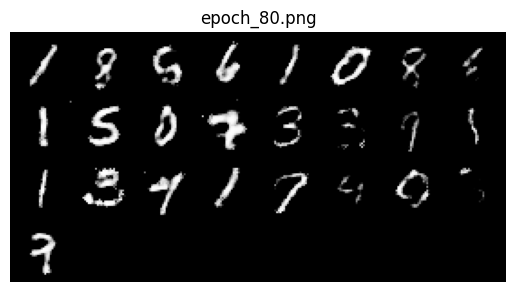

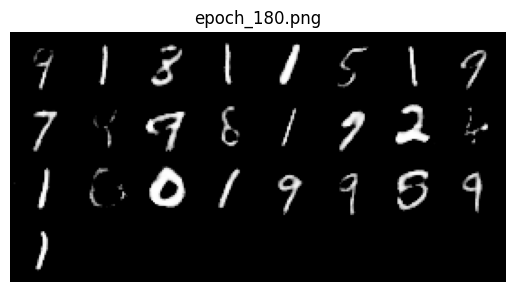

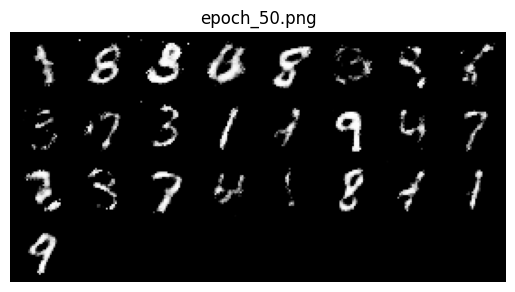

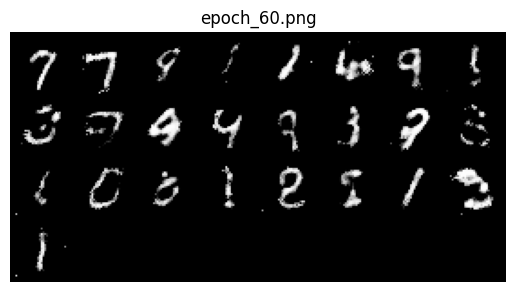

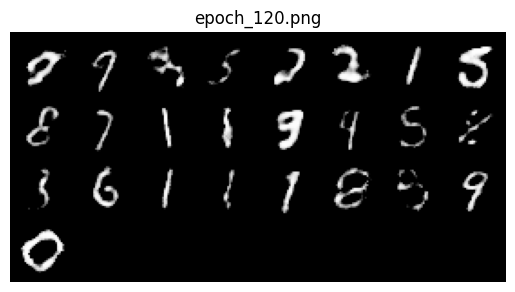

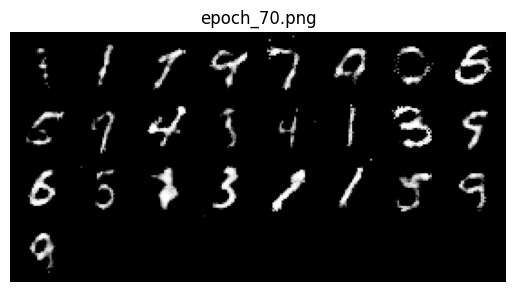

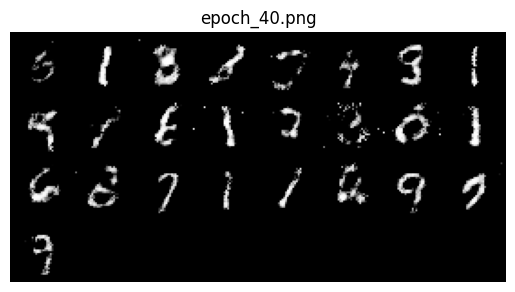

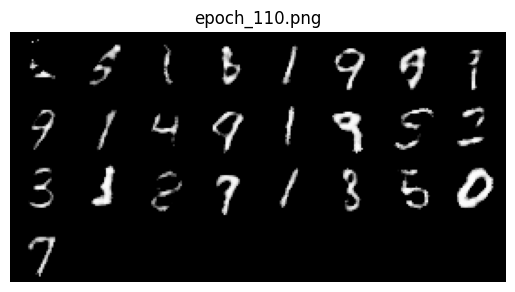

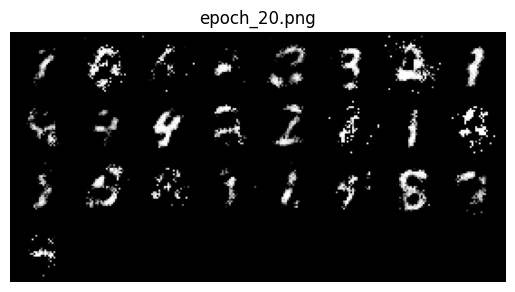

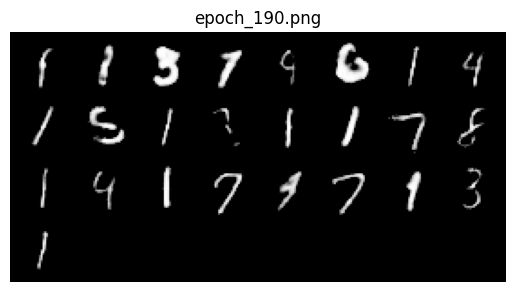

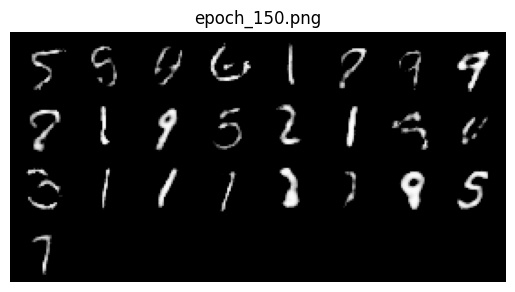

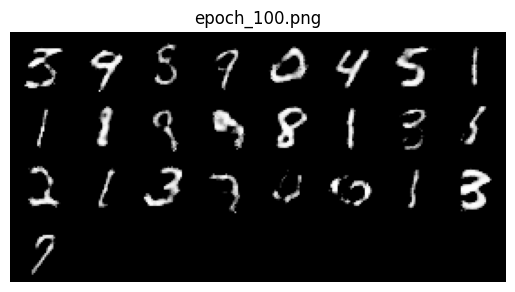

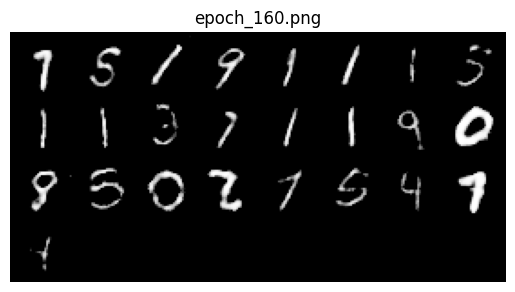

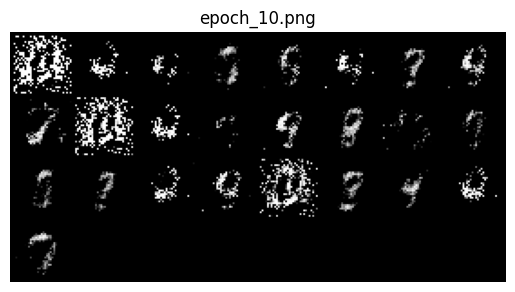

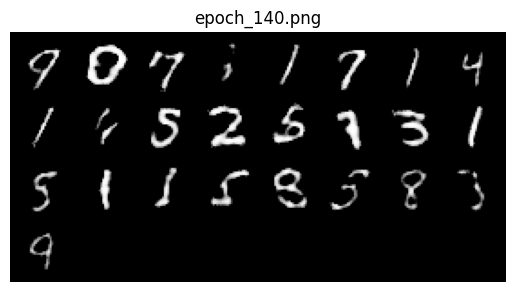

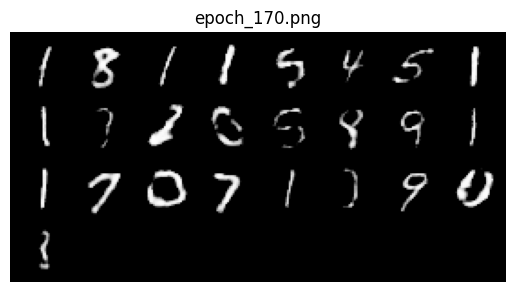

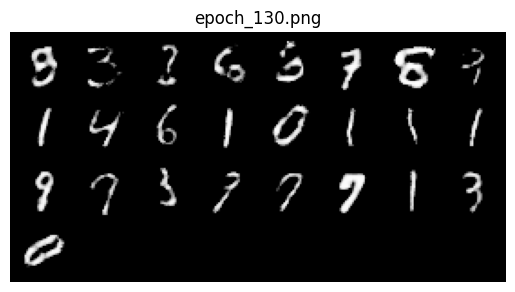

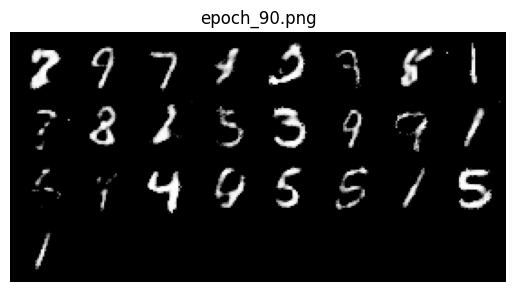

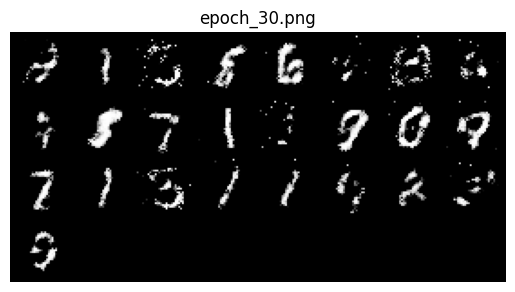

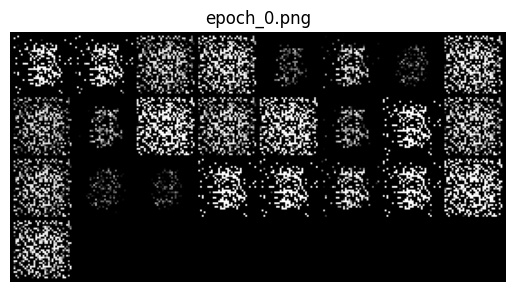

In [ ]:
import os
import matplotlib.pyplot as plt
from PIL import Image

# Path to your image folder
folder_path = '/content/images'

# Get list of all files in the folder
images = os.listdir(folder_path)

# Create subplots based on number of images

# Iterate and plot each image
for i, image_name in enumerate(images):
    # Construct full image path
    image_path = os.path.join(folder_path, image_name)
    image = Image.open(image_path)
    plt.imshow(image)
    plt.axis('off')
    plt.title(image_name)
    plt.show()

